# Implement CIDA with the Rotated MNIST dataset

In [1]:
# import these libraries for this re-implementation
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.transforms.functional import rotate
from torch.optim import Adam
import torch.optim.lr_scheduler as lr_scheduler

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

import time
import os

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from PIL import Image
from progressbar import ProgressBar
from prettytable import PrettyTable
from tensorboardX import SummaryWriter as Logger
from utils import * # modules, models and methods

## Experiment Overview
### Setup
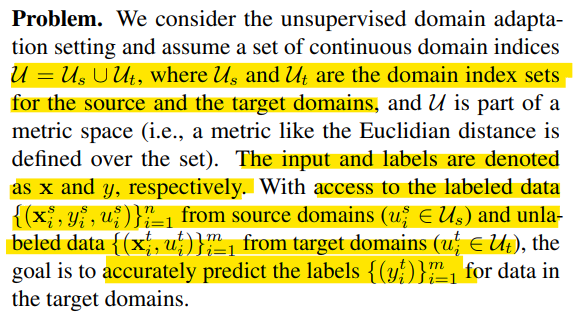

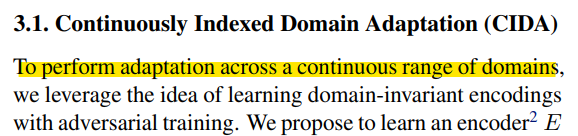

I think I misunderstood it, thinking that this CIDA paper was continual domain adaptation, but it is not. It is unsupervised domain adaptation across multiple domains.

### UDA and CDA
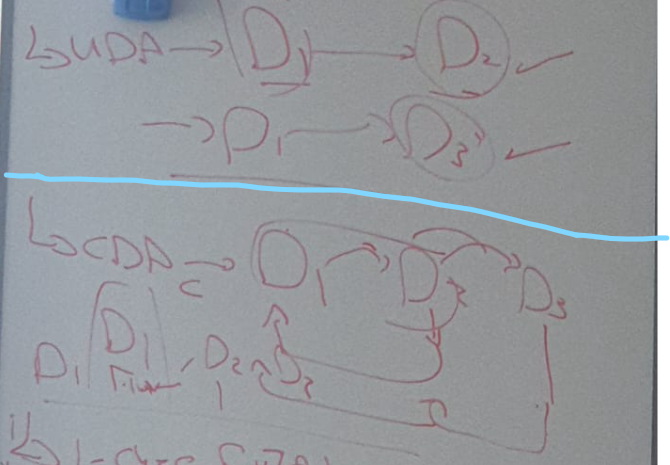

#### Source domain: 
Domain 0 (0 to 45 degrees)

#### Target domains: 
Domains 1 to 7 (45 to 360 degrees, interval of 45 degrees)

<br>

Source domain is labelled, and target domains are unlabelled. And the classes are the same for all the domains (digits 0 to 9)

### Input Data
For this benchmark, the data comes from the MNIST dataset and is augmented with angle rotations to represent domains.

Input data comprises of:
1. x (image data)
2. y (labels (not usable in target domains))
3. u (domain index (angle rotation normalized from 0 to 360 to 0 to 1)
4. is_source (indicates if it is from source or target domains)

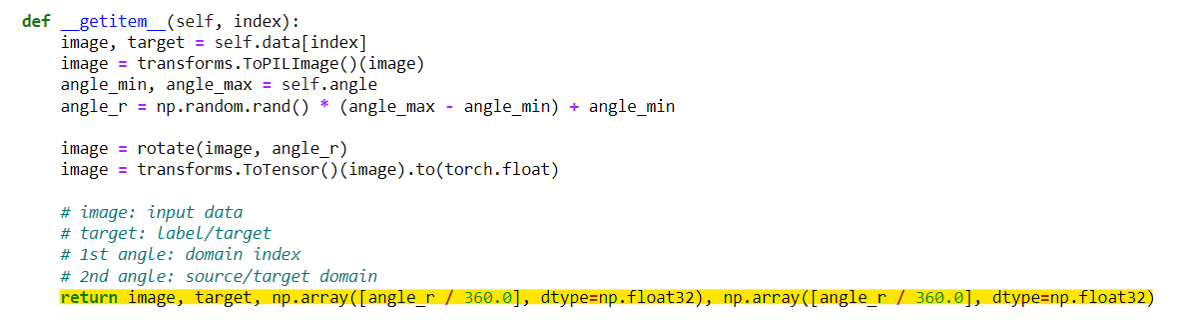

### WHY? (in codes)
### Learn/Train
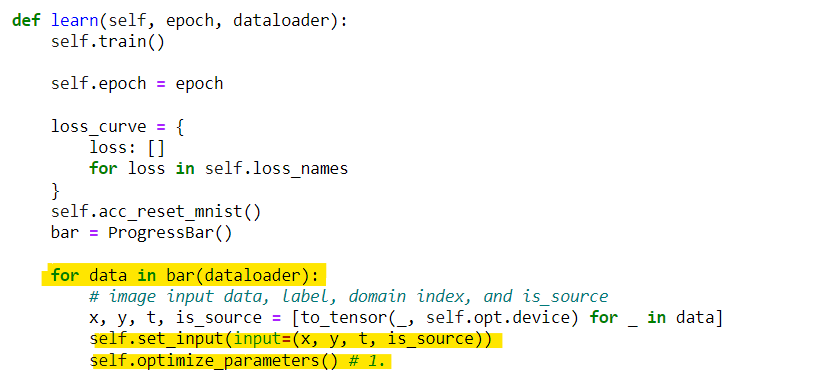

### Unlabelled data (optimize_parameters())
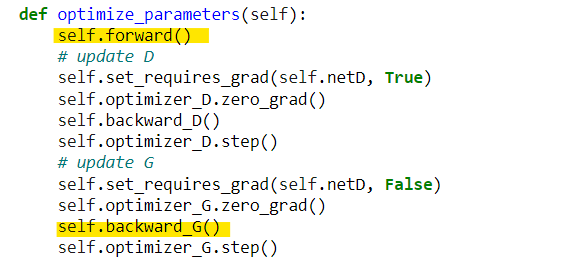

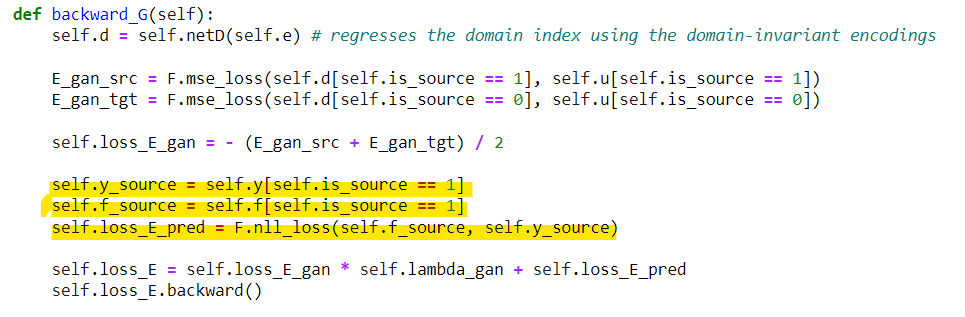

### Accuracy metrics only (no forgetability)
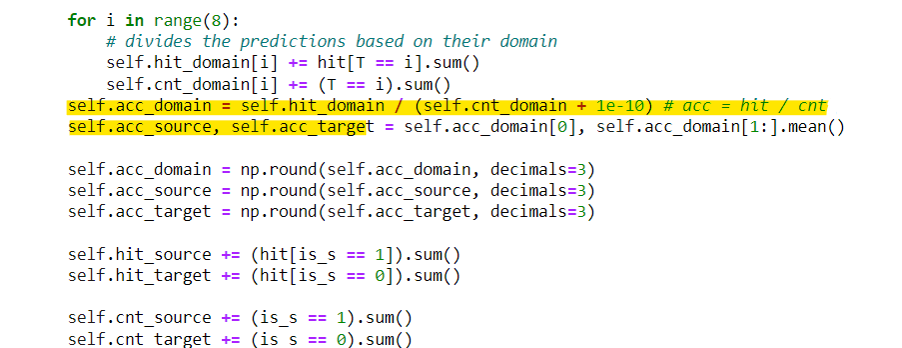

## Create CIDA
CIDA comprised of three modules: encoder, discriminator, and predictor.

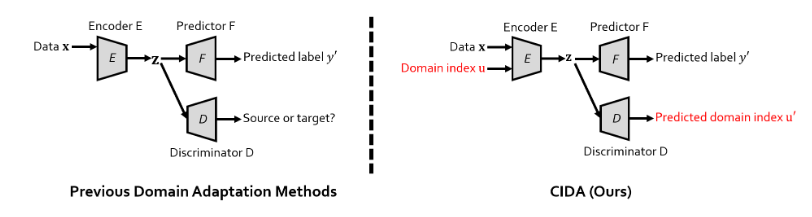

### Encoder
For the Rotated MNIST benchmark, two augmentations, Spatial Transformer Network (STN) and dropout layers were added to provide the encoding model with a stronger inductive bias.

The encoder takes in the image and domain index as input.

### Discriminator
The discriminator regresses the domain index.

## Model Benchmark

### View the Dataset

Source


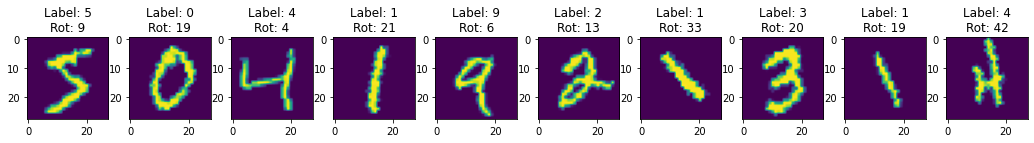

Sub Target #1


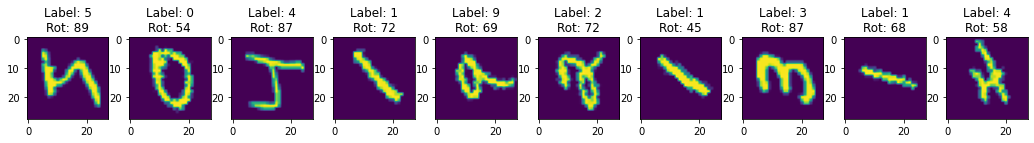

Sub Target #2


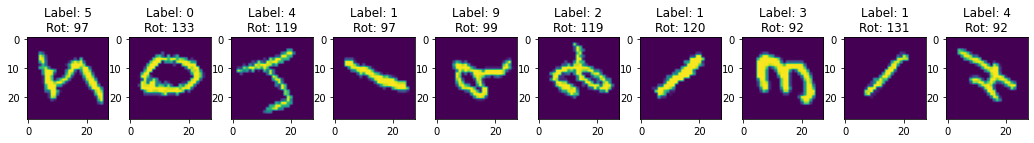

Sub Target #3


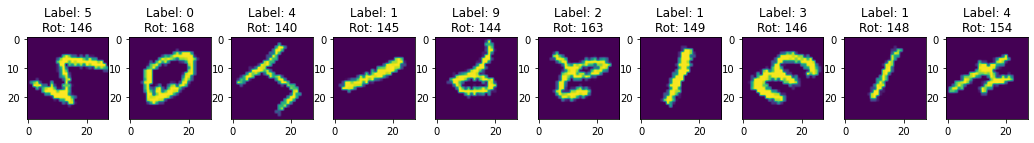

Sub Target #4


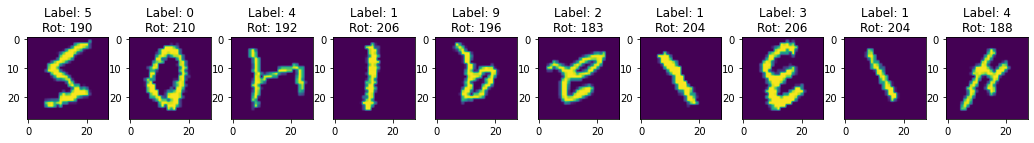

Sub Target #5


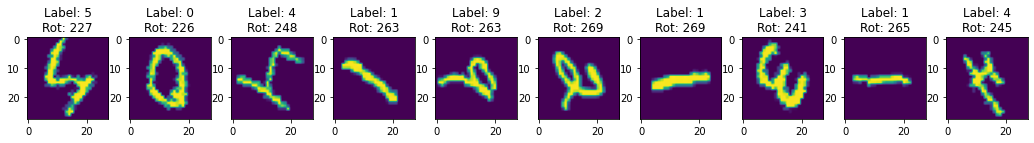

Sub Target #6


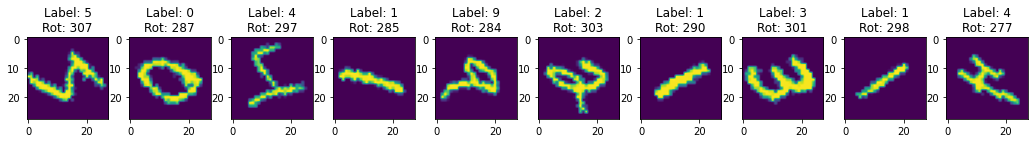

Sub Target #7


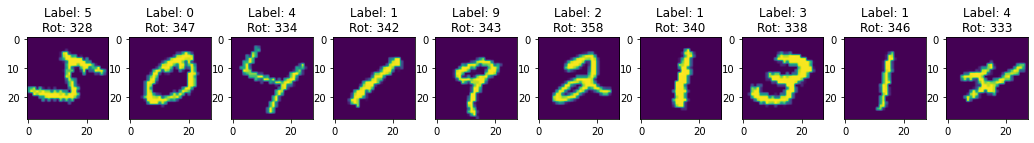

In [2]:
# for each domain (45 degree angle rotation interval)
for i in range(8):
    dataset = RotatedMNIST(angle=(i * 45, i * 45 + 45))
    
    if i == 0:
        name = 'Source'
    else:
        name = f'Sub Target #{i}'
    print(name)
    fig, ax = plt.subplots(1, 10, figsize=(18, 1.5))
    # preview first 10 images
    for j in range(10):
        image, label, angle, _ = dataset[j]
        angle = angle[0] * 360
        ax[j].imshow(image[0])
        ax[j].set_title(f'Label: {label}\nRot: {angle:.0f}')
    plt.show()
    plt.close()        

### Setting Configurations (opt)

In [3]:
# relaod modules before executing user code
%load_ext autoreload
%autoreload 2

# set configurations with EasyDict()
from easydict import EasyDict
opt = EasyDict()
opt.model = "CUA"
opt.device = "cuda"
set_default_args(opt)
print_args(opt)

# build dataset and dataloaders
dataset = RotatedMNIST(angle=(0, 360))
train_dataloader = DataLoader(
    dataset=dataset, 
    shuffle=True, 
    batch_size=opt.batch_size, 
    num_workers=4
)
test_dataloader = DataLoader(
    dataset=dataset, 
    shuffle=True, 
    batch_size=opt.batch_size, 
    num_workers=4
)

Training result will be saved in  ./dump/rotatingMNIST-Kidd_CUA
model: CUA
device: cuda
dropout: 0
nh: 512
nc: 10
nz: 100
num_epoch: 2
batch_size: 100
lr: 0.0002
weight_decay: 0.0005
beta1: 0.9
lambda_gan: 2.0
exp: rotatingMNIST-Kidd_CUA
outf: ./dump/rotatingMNIST-Kidd_CUA
dim_domain: 1
continual_da: True
num_da_step: 7
num_epoch_pre: 2
num_epoch_sub: 2
lr_decay_period: 50
lambda_rpy: 1.0


### CIDA

In [4]:
model1 = CIDA(opt)
model1 = model1.to(opt.device)

In [5]:
"""
Training the model from the scratch
"""
best_acc_target = 0
# Single Step Domain Adaptation
for epoch in range(opt.num_epoch):
    model1.learn(epoch, train_dataloader)
    if (epoch + 1) % 10 == 0:
        acc_target = model1.eval_mnist(test_dataloader)
        if acc_target > best_acc_target:
            print('Best acc target. saved.')
            model1.save()

C:\Users\sngki\OneDrive - Temasek Polytechnic (1)\Year 3 Sem 2\Internship\Deep Learning with PyTorch\CIDA\rotatingMNIST-Kidd\utils.py:216: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:2499.)
  _, evs = torch.symeig(A, eigenvectors=True)
C:\Users\sngki\miniconda3\envs\CIDA\lib\site-packages\torch\nn\functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old be

[Train][0] Loss: D 0.102 E_gan -0.089 E_pred 0.695
[Train][0] Acc: source 0.814 (6202.0/7623) target 0.401 (21105.0/52377)


[Train][1] Loss: D 0.079 E_gan -0.075 E_pred 0.195
[Train][1] Acc: source 0.947 (7117.0/7516) target 0.478 (25039.0/52484)


### CUA

In [6]:
model2 = CUA(opt)
model2 = model2.to(opt.device)

In [8]:
"""
Training the model from the scratch
"""
best_acc_target = 0
# continual DA training
continual_dataset = ContinuousRotatedMNIST()

print('===> pretrain the classifer')
model2.prepare_trainer(init=True)
for epoch in range(opt.num_epoch_pre):
    model2.learn(epoch, train_dataloader, init=True)
    if (epoch + 1) % 10 == 0:
        model2.eval_mnist(test_dataloader)
print('===> start continual DA')
model2.prepare_trainer(init=False)
for phase in range(opt.num_da_step):
    continual_dataset.set_phase(phase)
    print(f'Phase {phase}/{opt.num_da_step}')
    print(f'#source {len(continual_dataset.ds_source)} #target {len(continual_dataset.ds_target[phase])} #replay {len(continual_dataset.ds_replay)}')
    continual_dataloader = DataLoader(
        dataset=continual_dataset,
        shuffle=True,
        batch_size=opt.batch_size,
        num_workers=4,
    )
    for epoch in range(opt.num_epoch_sub):
        model2.learn(epoch, continual_dataloader, init=False)
        if (epoch + 1) % 10 == 0:
            model.eval_mnist(test_dataloader)

    target_dataloader = DataLoader(
        dataset=continual_dataset.ds_target[phase],
        shuffle=True,
        batch_size=opt.batch_size,
        num_workers=4,
    )
    acc_target = model2.eval_mnist(test_dataloader)
    if acc_target > best_acc_target:
        print('Best acc target. saved.')
        model2.save()
    data_tuple = model2.gen_data_tuple(target_dataloader)
    continual_dataset.ds_replay.update(data_tuple)  

(60000, 1, 28, 28) (60000,) (60000, 1)
===> pretrain the classifer
======>preparing trainer True


100% |########################################################################|


[Train][0] Loss: E_pred 0.478
[Train][0] Acc: source 0.857 (6402.0/7472) target 0.306 (16057.0/52528)


100% |########################################################################|


[Train][1] Loss: E_pred 0.186
[Train][1] Acc: source 0.943 (6879.0/7297) target 0.347 (18299.0/52703)
===> start continual DA
======>preparing trainer False
Phase 0/7
#source 60000 #target 60000 #replay 60000


100% |########################################################################|


[Train][0] Loss: D 1.332 E_replay 0.227 E_gan 0.743
[Train][0] Acc: source 0.937 (56247.0/60000) target 0.123 (51755.0/60000)


100% |########################################################################|


[Train][1] Loss: D 1.332 E_replay 0.144 E_gan 0.759
[Train][1] Acc: source 0.954 (57261.0/60000) target 0.132 (55493.0/60000)

Eval MNIST: [0.959 0.924 0.606 0.318 0.35  0.376 0.334 0.652] src: 0.959 tgt:0.508
Best acc target. saved.
===> generate new replay dataset!
generated:  (60000, 1, 28, 28) (60000,) (60000, 1)
Phase 1/7
#source 60000 #target 60000 #replay 120000


100% |########################################################################|


[Train][0] Loss: D 1.295 E_replay 0.105 E_gan 0.808
[Train][0] Acc: source 0.940 (56385.0/60000) target 0.120 (50312.0/60000)


100% |########################################################################|


[Train][1] Loss: D 1.296 E_replay 0.086 E_gan 0.788
[Train][1] Acc: source 0.947 (56803.0/60000) target 0.122 (51349.0/60000)

Eval MNIST: [0.947 0.904 0.823 0.465 0.35  0.37  0.373 0.663] src: 0.947 tgt:0.564
Best acc target. saved.
===> generate new replay dataset!
generated:  (60000, 1, 28, 28) (60000,) (60000, 1)
Phase 2/7
#source 60000 #target 60000 #replay 180000


BrokenPipeError: [Errno 32] Broken pipe